In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

<h3> (1) Truncated Poisson using Metropolis-Hastings </h3>

The following function evaluates the unnormalized distribution:

In [5]:
def g(A, i):
    return A**i/np.math.factorial(i)

We also define a function able to compute the true probability distribution for the truncated Poisson, to be compared with the results of the Metropolis Hastings algorithm.

In [6]:
def poisson():
    n = 10
    A = 8
    d = np.empty(n+1)
    for j in range(n+1):
        d[j] = g(A,j)
    return d/np.sum(d)

The Metropolis Hastings algorithm is implemented by the following function:

In [7]:
def metropolis_hastings(init = 0, size = 10000):
    A = 8
    m = 10
    res = [init] # res contains the final sampled values
    n = 1
    x = init
    while n < size:
        
        # sampling the new proposal
        delta = np.random.randint(-m,m+1)
        y = np.mod(x + delta, m+1)
        gy = g(A, y)
        gx = g(A, x)

        #acceptance or rejection of the proposal
        if gy >= gx:
            res.append(y)
            x = y
        else:
            p = np.random.rand(1)
            if (p < gy/gx):
                res.append(y)
                x = y
            else:
                res.append(x)
        n += 1
    return res

For visual purposes, we plot the histogram of the sampled values, along with the true probability distribution.

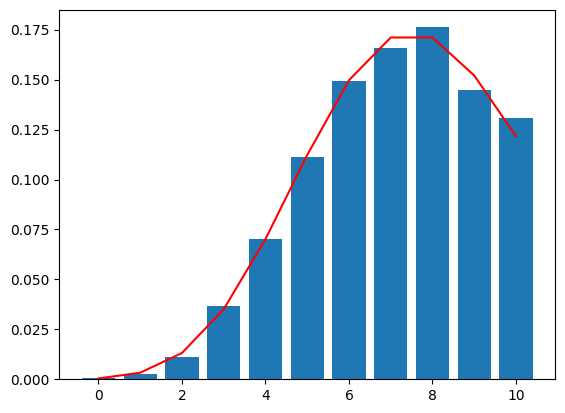

In [10]:
vals = metropolis_hastings()
unique = np.unique(vals)
counts = np.empty(11)
for i,u in enumerate(unique):
    counts[i] = np.sum(vals == u)

plt.bar(range(11), counts/len(vals))
plt.plot(poisson(), color = 'Red')
plt.show()

From the plot, it seems we achieved the desired result, but we also performed a set of χ2 tests. Then, we plot the histogram of the found p-values. Note that at each iteration, when sampling new values, we save only every four samples to reduce the dependence of one sample with the others, otherwise we would not satisfy the assumptions of the χ2 test. 

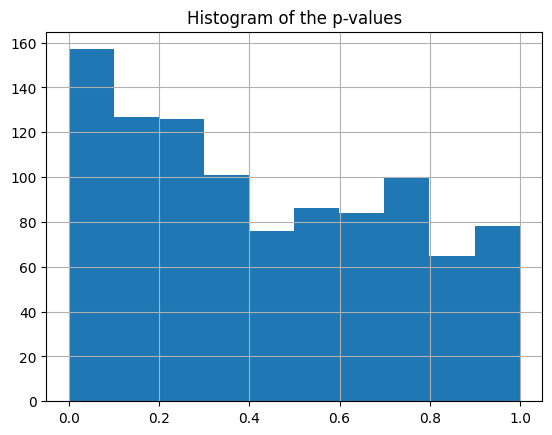

In [14]:
p_values = []
for i in range(1000):
    vals = metropolis_hastings()[::4] # the values are dependent with each other
    unique = np.unique(vals)
    counts = np.empty(11)
    for i,u in enumerate(unique):
        counts[i] = np.sum(vals == u)
    p_values.append(stats.chisquare(counts, poisson()*len(vals))[1])

plt.hist(p_values)
plt.title('Histogram of the p-values')
plt.grid()
plt.show()

The distribution of the p-values is somewhat uniform (there is still a little dependence between the samples). Overall, we can conclude that our implementation of the algorithm is satisfactory and gives the desired results

<h3> (2) Metropolis-Hastings in 2D </h3>

We define a utility function able to display the results given by our implementations of the algorithms, along with the true distribution for comparison.

In [15]:
def show_comparison2D(estimated, true_frequency):
    counts = np.empty((11,11))
    for i in range(11):
        for j in range(11):
            counts[i,j] = np.sum(np.logical_and(estimated[:,0]==i, estimated[:,1]==j))
            
    fig, axs = plt.subplots(1,2, figsize = (12,12))
    axs[0].imshow(counts, cmap = 'gray')
    axs[0].set_title('Estimated Frequency')
    axs[1].imshow(true_frequency, cmap = 'gray')
    axs[1].set_title('True Frequency')
    plt.show()

The following function evaluates the unnormalized distribution:

In [16]:
def g_2D(A1, A2, i, j):
    return A1**i/np.math.factorial(i)*A2**j/np.math.factorial(j)

We also need to have the true values of the distribution when comparing the results of the asked algorithms:

In [17]:
def poisson2D():
    res = np.zeros((11,11))
    for i in range(11):
        for j in range(0, 11 - i):
            res[i,j] = g_2D(4,4,i,j)
    return res/np.sum(res)

For question 2a, we implement the proposal distribution as a function able to generate new states uniformly. In other words, the output of the function is a pair [i, j] where 0 <= i + j <= 10. There are therefore 66 possible states.

In [18]:
possible_states = [[i, j] for i in range(11) for j in range(11 - i)]

def getNewIJ():
    idx = int(np.floor(np.random.uniform(0,1)*66))
    return possible_states[idx]

The algorithm is implemented as follows

In [19]:
def metropolis_hastings2D(init = [0,0], size = 100000):
    A1 = 4
    A2 = 4
    m = 10

    res = np.empty((size,2))
    n = 1
    res[0,:] = init
    i = init[0]
    j = init[1]

    while n < size:
        
        #sampling a new proposal
        new_i, new_j = getNewIJ()

        #acceptance or rejection of the proposal
        gy = g_2D(A1, A2, new_i, new_j)
        gx = g_2D(A1, A2, i, j)
        if gy >= gx:
            res[n,:] = [new_i, new_j]
            i = new_i
            j = new_j
        else:
            p = np.random.rand(1)
            if (p <= gy/gx):
                res[n,:] = [new_i, new_j]
                i = new_i
                j = new_j
            else:
                res[n,:] = [i,j]
        n += 1
    return res

We visualize the results given by the algorithm to see if they are similar to the true distribution

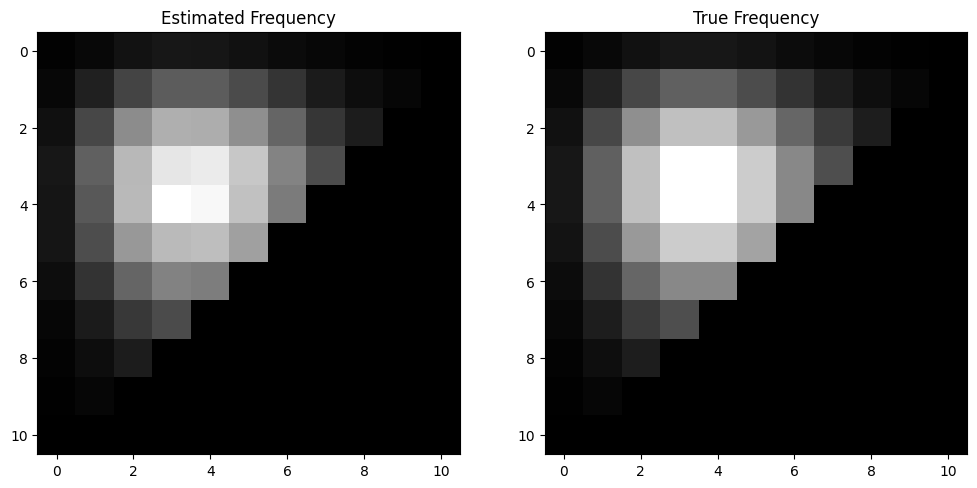

In [20]:
vals = metropolis_hastings2D()
show_comparison2D(vals, poisson2D()*vals.shape[0])

We also perform χ2 tests to see if the p-values are uniformly distributed between 0 and 1. We keep one sample every four to reduce the dependence between the values.

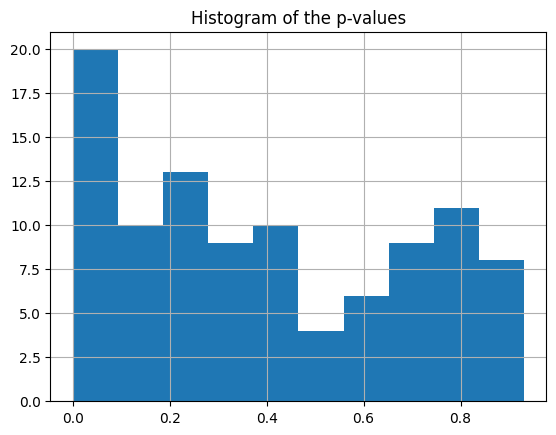

In [22]:
true_f = poisson2D()
mask = true_f !=0
p_values = []
for i in range(100):
    vals = metropolis_hastings2D()[::4] # the values are dependent with each other
    counts = np.empty((11,11))
    for i in range(11):
        for j in range(11):
            counts[i,j] = np.sum(np.logical_and(vals[:,0]==i, vals[:,1]==j))
    true_f = poisson2D()*vals.shape[0]
    p_values.append(stats.chisquare(counts[mask].flatten(), true_f[mask].flatten())[1])
plt.hist(p_values)
plt.title('Histogram of the p-values')
plt.grid()
plt.show()

There is still probably some dependence between the samples since the p-values are not perfectly uniformly distributed, and some techniques to reduce it even more could be applied, but we can say that the implementation gives the desired results.

<h3> (2b) Metropolis Hastings in 2D - Coordinate Wise <h3>

The implementation of the algorithm is very similar the Question 2a, but differs in the sampling of the new state proposal: at each iteration, we fix one direction and we move randomly along the other, generating a new proposal state that will be accepted or rejected.

In [23]:
def metropolis_hastings2D_coord(init = [0,0], size = 10000):
    A1 = 4
    A2 = 4
    m = 10

    res = np.empty((size,2))
    n = 1
    res[0,:] = init
    i = init[0]
    j = init[1]

    direction = True
    while n < size:

        # sampling a new proposal        
        if direction == True:
            new_i = np.random.randint(0, m - j + 1)
            new_j = j
        else:
            new_i = i
            new_j = np.random.randint(0, m - i + 1)
        direction = not direction

        # acceptance or rejection of the new proposal
        gy = g_2D(A1, A2, new_i, new_j)
        gx = g_2D(A1, A2, i, j)
        if gy >= gx:
            res[n,:] = [new_i, new_j]
            i = new_i
            j = new_j
        else:
            p = np.random.rand(1)
            if (p < gy/gx):
                res[n,:] = [new_i, new_j]
                i = new_i
                j = new_j
            else:
                res[n,:] = [i,j]
        n += 1

    return res

As before we visualize the results for a run to check if the results are what we expect

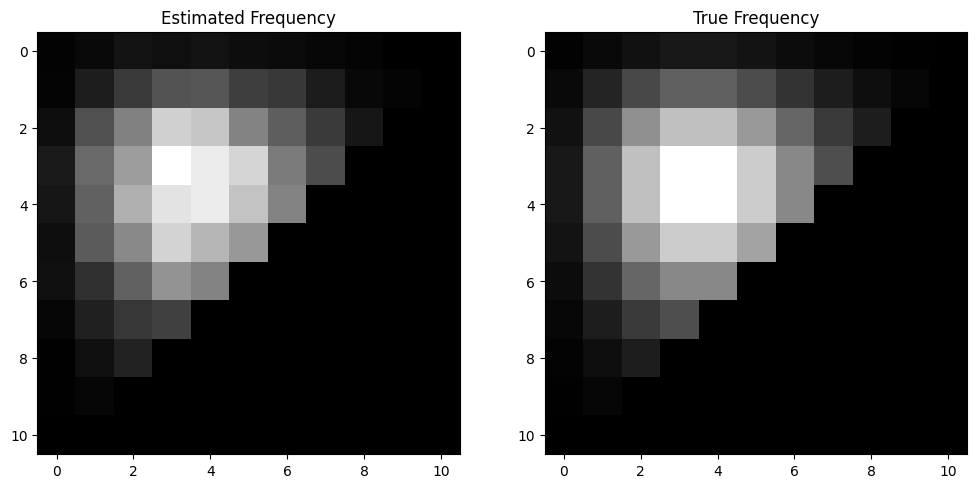

In [24]:
vals = metropolis_hastings2D_coord()
show_comparison2D(vals, poisson2D()*vals.shape[0])

We perform the usual set of tests to check if the samples indeed come from the desired distribution.

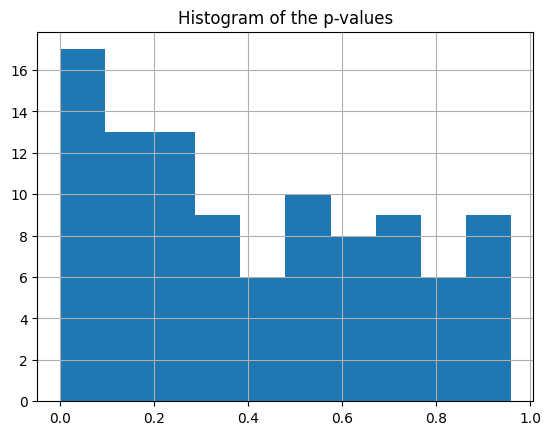

In [26]:
true_f = poisson2D()
mask = true_f !=0

p_values = []
for i in range(100):
    vals = metropolis_hastings2D_coord()[::4] # the values are dependent with each other
    counts = np.empty((11,11))
    for i in range(11):
        for j in range(11):
            counts[i,j] = np.sum(np.logical_and(vals[:,0]==i, vals[:,1]==j))
    true_f = poisson2D()*vals.shape[0]
    p_values.append(stats.chisquare(counts[mask].flatten(), true_f[mask].flatten())[1])

plt.hist(p_values)
plt.title('Histogram of the p-values')
plt.grid()
plt.show()

<h3> (2c) Gibbs sampling coordinate wise </h3>

The following function outputs a vector of probabilities. This probability masses represents the conditional probability of i given j when sampling new states in the Gibbs algorithm. Since the distribution is symmetric the probability distribution of j given i is the same of the previous one, so we do not distinguish between the two cases.

In [27]:
def condProb(z):
    probs = poisson2D()
    s = np.sum(probs[z,:])
    p = np.zeros(11)
    for k in range(len(p)):
        p[k] = probs[z,k]/s
    return p

The algorithm with Gibbs sampling is implemented as follows. When sampling the new states, first we move in one direction fixing the other (using the conditional probability defined above) and then we move in the other direction, again using the conditional probability.

In [28]:
def metropolis_hastings2D_gibbs(init = [0,0], size = 10000):
    A1 = 4
    A2 = 4
    m = 10

    res = np.empty((size,2))
    n = 1
    res[0,:] = init
    i = init[0]
    j = init[1]
    while n < size:
        p = condProb(j)
        new_i = np.random.choice(np.arange(11), p = p)
        p = condProb(int(new_i))
        new_j = np.random.choice(np.arange(11), p = p)

        res[n, :] = [new_i, new_j] #saving the new state
        i = new_i
        j = new_j

        n += 1
    return res

We visually inspect the results

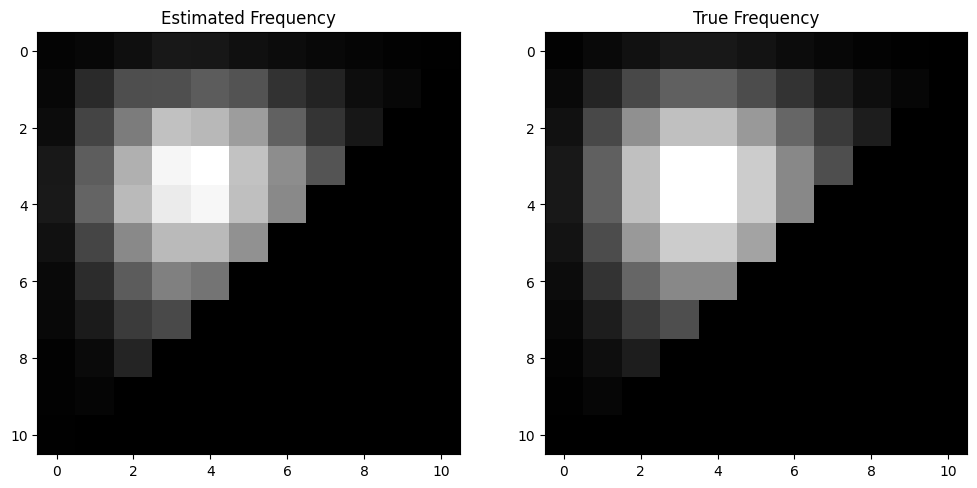

In [29]:
vals = metropolis_hastings2D_gibbs()
show_comparison2D(vals, poisson2D()*vals.shape[0])

We perform the usual set of χ2 tests to see if the samples come indeed from the desired distribution. If so, the p-values should be uniformly dsitributed between 0 and 1, as seen in the plot below.

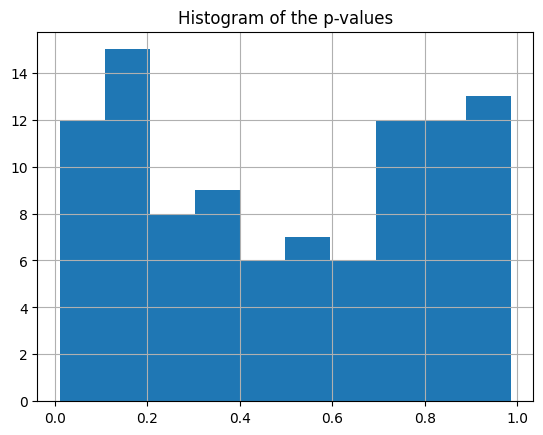

In [31]:
true_f = poisson2D()
mask = true_f!=0
p_values = []
for i in range(100):
    vals = metropolis_hastings2D_gibbs()[::4] # the values are dependent with each other
    counts = np.empty((11,11))
    for i in range(11):
        for j in range(11):
            counts[i,j] = np.sum(np.logical_and(vals[:,0]==i, vals[:,1]==j))
    true_f = poisson2D()*vals.shape[0]
    p_values.append(stats.chisquare(counts[mask].flatten(), true_f[mask].flatten())[1])

plt.hist(p_values)
plt.title('Histogram of the p-values')
plt.grid()
plt.show()

<h3> (3) Bayesian problem  </h3>

Point a

In [185]:
sampled = np.random.multivariate_normal([0,0], cov = [[1,1/2],[1/2,1]])
params = np.exp(sampled)

Point b

In [186]:
xlist = stats.norm.rvs(params[0], np.sqrt(params[1]), size = 10)
xlist

array([3.66326288, 1.13598333, 2.49667646, 2.40896704, 1.92840079,
       1.12792588, 4.53791058, 3.24103768, 3.97991259, 2.61288613])

Point c

In [187]:
def g(Xi, theta, psi):
    A = 1/(np.sqrt(6*np.pi*psi)*np.pi*psi*theta)**Xi.shape[0]
    return np.exp(np.sum(-(Xi - theta)**2/psi - (np.log(theta)**2 - np.log(theta)*np.log(psi)+np.log(psi)**2)*2/3))/A


Point d

[array([2.08172597, 1.95885762]), array([1.51008553, 4.62790657]), array([3.48975325, 4.80962066]), array([3.26049385, 5.76187117]), array([2.87717984, 5.19712318]), array([2.48186802, 4.51815146]), array([4.3366264 , 4.97060766]), array([2.31988659, 4.47779247]), array([2.92531869, 5.07804811]), array([2.58477238, 4.16191525]), array([2.88564667, 2.87450355]), array([3.35363262, 4.72378843]), array([2.59622927, 5.52562446]), array([2.60189726, 5.70612546]), array([3.23151049, 7.21614371]), array([2.50024223, 6.3235107 ]), array([2.69104936, 5.0747333 ]), array([3.72210287, 5.25565048]), array([3.37013168, 5.50806892]), array([3.13871613, 5.17460852]), array([2.40224587, 5.5946907 ]), array([2.43586021, 5.42283811]), array([2.77540445, 4.59815889]), array([2.64943109, 5.44406542]), array([2.83661348, 4.65304331]), array([2.92343919, 5.63396837]), array([2.96851415, 5.49977278]), array([ 3.7262205 , 11.30310893]), array([2.81845593, 7.61131874]), array([3.04030375, 5.34708625]), array([

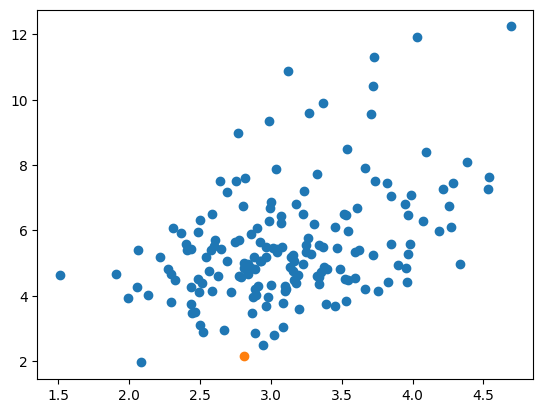

In [190]:
theta_psi_list = []
x_log = np.random.multivariate_normal([0,0], cov = [[1,1/2],[1/2,1]])
x = np.exp(x_log)
for i in range(10000):
    y_log = np.random.multivariate_normal([0,0], cov = [[1,1/2],[1/2,1]])
    y = np.exp(y_log)

    gx = g(xlist, x[0], x[1])
    gy = g(xlist, y[0], y[1])

    if gy >= gx:
            theta_psi_list.append(y)
            x = y
    else:
        p = np.random.rand(1)
        if (p < gy/gx):
            theta_psi_list.append(y)
            x = y

print(theta_psi_list)
print(params)

theta_psi_list = np.array(theta_psi_list)

plt.scatter(theta_psi_list[:,0], theta_psi_list[:,1])
plt.scatter(params[0], params[1])
plt.show()

Point e

In [112]:
xlist = stats.norm.rvs(params[0], np.sqrt(params[1]), size = 10)

theta_psi_list = []
x_log = np.random.multivariate_normal([0,0], cov = [[1,1/2],[1/2,1]])
x = np.exp(x_log)
for i in range(100):
    y_log = np.random.multivariate_normal([0,0], cov = [[1,1/2],[1/2,1]])
    y = np.exp(y_log)

    gx = g(xlist, x[0], x[1])
    gy = g(xlist, y[0], y[1])

    if gy >= gx:
            theta_psi_list.append(y)
            x = y
    else:
        p = np.random.rand(1)
        if (p < gy/gx):
            theta_psi_list.append(y)
            x = y

theta_psi_list, params

([array([2.2386218 , 1.02655611]),
  array([2.09154063, 0.87900666]),
  array([1.89080324, 1.19090041]),
  array([1.94313462, 1.09939115])],
 array([2.45275687, 0.77538279]))